<p style="text-align: center;"><img src="http://www.ucm.es/logo/ucm.png" alt="ucm" style="height: 100px;"/>   <img src="https://www.ucm.es/data/cont/media/www/pag-18458/logo_aocg.jpg" alt="aocg" style="height: 100px;"/> 

&nbsp;

<div align="center"> 
<font size=5> Universidad Complutense de Madrid</font>
</div>
    
<div align="center"> 
<font size=4> Grupo Computense de Óptica Aplicada </font>
</div>
&nbsp;

&nbsp;



    
<div align="center"> 
<font size=6> Análisis de errores: Matrices de Jones/Mueller</font>
</div>

- **Para**: SLM Pluto

- **Fecha**: 2022/02/21
        
- **Autores**: Ángela Soria García

- **Objetivos**: Análisis de los errores en las matrices de Jones/Mueller en función de los ángulos de los polarizadores/retardadores

- **Descripción** Calculamos la variación de las matrices de Jones/Mueller cuando el ángulo de las ópticas varía unos pocos ángulos (+/- 2 grados)

In [87]:
import numpy as np
import matplotlib.pyplot as plt

from py_pol.jones_matrix import Jones_matrix, create_Jones_matrices
from py_pol.jones_vector import Jones_vector, degrees
from py_pol.mueller import Mueller
from py_pol.stokes import Stokes

from py_lab.setups.slm_calibration import *

Creamos la matriz de Jones de forma teórica:

In [88]:
num_gl = 256
phase_max=np.pi
p1 = np.linspace(1, 0.25, num_gl)
p2 = np.linspace(1, 0.25, num_gl)
R = np.linspace(0, phase_max, num_gl)
gl = np.arange(0,num_gl,1,dtype=int)

In [89]:
#J = Jones_matrix().diattenuator_retarder_linear(p1=p1,p2=p2,R=R)
J = Jones_matrix().diattenuator_perfect(azimuth=R)
J00,J01,J10,J11 = J.parameters.components(out_number=False,draw=False,verbose=False);
det = J.parameters.det(draw=False)
theorical_components = [np.abs(J00),np.abs(J01),np.abs(J10),np.abs(J11),np.abs(det),np.angle(J01)-np.angle(J00),np.angle(J10)-np.angle(J00),np.angle(J11)-np.angle(J00)]

Estudiamos las posibilidades de generar ángulos de forma aleatoria. En primer lugar asumimos que la distribución es gaussiana. Escogemos que la media es nula y la desviación estándar de 0.02 radianes, es decir, un error en las ópticas de +/- 1.14º

In [183]:
mu, sigma = 0, 0.02 # mean and standard deviation
s = np.random.normal(mu, sigma, 500)

In [184]:
count, bins, _ = plt.hist(s, 30, density=True)
plt.plot(bins,1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.show()

A continuación, calculamos los ángulos a los que hay que colocar las ópticas, es decir, los autoestados. Después calculamos la transmisión del sistema en función del nivel de gris:

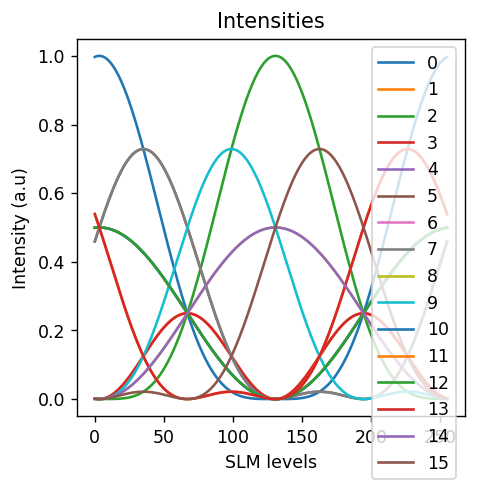

In [128]:
I_down = []
I_up=[]
levels = np.arange(0,num_gl)
has_draw=True
for ind in range(16):
    for ort in range(2):
        
        angles = Calculate_Angles(
                ind,
                ort,
                mirrors=[False,False],
                check_repeat=False,
                return_angles=True,
                add_zero=False)
        
        variation = 0.04
        angles_down = angles - variation
        angles_up = angles + variation 
        #Correción para que los ángulos sean siempre mayores que 0.
        angles_down[angles_down<0] = 2*np.pi - variation
      
        amp_down,phase_down = Calculate_Transmission(angles_down,J,E0=None)
        amp_up,phase_up = Calculate_Transmission(angles_up,J,E0=None)
        
        if ort == 0:
            I_down.append(amp_down)
            I_up.append(amp_up)
            
            if has_draw:   
                plt.title('Intensities')
                plt.xlabel('SLM levels')
                plt.ylabel('Intensity (a.u)')
                plt.plot(levels,amp_up) 

                plt.legend(range(len(PSA_az)))

Con las intensidades calculamos las matrices de Jones con el método Hoyo extendido. Por eso solo calculamos las 16 primeras intensidades:

In [130]:
comp_down = Metodo_Hoyo_Ext(I_down, None)
comp_up = Metodo_Hoyo_Ext(I_up,None)

In [135]:
colors = ('k+','g')
titles = ('|J0|', '|J1|', '|J2|', '|J3|', 'det', 'd1', 'd2', 'd3')
plt.figure(figsize=(18, 10))
for ind in range(8):
    plt.subplot(2,4,ind+1)
    plt.plot(levels[::10],comp_down[ind][::10],colors[0],markersize=3)
    plt.plot(levels[::10],comp_up[ind][::10],colors[0],markersize=3)
    plt.plot(levels,theorical_components[ind],colors[1],label='Theorical') 
        
    plt.title(titles[ind])
    plt.legend(loc='best')
    if ind<5:
        plt.ylim(-0.01,1)